# Starbucks Capstone Project

## Project Overview

Once every few days, Starbucks sends out an offer to users of the Starbucks rewards mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). However, customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. Therefore, there will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer. This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app.

## Problem Statement

Given the datasets below, the objective is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer reward, and to predict which users, who normally wouldn't make a purchase, would respond to a sent offer and make a purchase through it. This can be done by first answering a couple of questions:

* What percentage of users view offers? and what are their characteristics?
* What percentage of users respond to offers? and what percentage complete the offer after viewing it?
* How much do adevertisements contribute in user transactions?
* Can we predict whether a user will respond to an offer or not from demographics and offer reward?

## Metrics

<!-- ![precision.png](imgs/precision.png)
![f1score.png](imgs/f1score.png) -->

The F1 score is chosen to be the metric as it defines the harmonic mean of precision and recall taking both metrics into account.

<img src="imgs/precision.png" width="350"/>
<img src="imgs/f1score.png" width="250"/>

## Data Sets

The data is contained in three files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


## Data Understanding

#### Import Statements

In [63]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

pd.options.mode.chained_assignment = None



A quick look into our data:

In [64]:
print('portfolio',portfolio.shape)
print('profile',profile.shape)
print('transcript',transcript.shape)

portfolio (10, 6)
profile (17000, 5)
transcript (306534, 4)


In [65]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [66]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [67]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


# Data Preparation

Next we perform some data wrangling on each dataset so it can be used efficiently in the following sections.

**Portofolio**

In [68]:
# Generate dummy columns of categorical variables

# offer type dummies
off_dummies = pd.get_dummies(portfolio['offer_type'],prefix='is')

# Channels column dummies
ch_dummies = portfolio['channels'].apply(lambda x: str(x)[1:-1].replace('\'','')).str.get_dummies(sep = ', ')
# Remove white spaces from columns
ch_dummies.columns = ch_dummies.columns.str.strip()



# Concatinate new columns to portofolio and remove channels and offer_type columns
portfolio = pd.concat([portfolio,off_dummies,ch_dummies],axis=1).drop(['channels'],axis=1)

portfolio.head()

,reward,difficulty,duration,offer_type,id,is_bogo,is_discount,is_informational,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1


In [69]:
portfolio

,reward,difficulty,duration,offer_type,id,is_bogo,is_discount,is_informational,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,0,1,0,1,1,0,1


**Profile**

In [70]:
# format 'became_member_of' column to timestamp
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'],format='%Y%m%d')

# Fill null values in income column with mean of incomes
# profile.income = profile.income.fillna(profile.income.mean())

# Classify gender into M, F, and O, so gender with None values will be replaced by 'O'
profile['gender'] = profile['gender'].apply(lambda x: 'O' if x is None else x)

# gender dummies
gender_dummies = pd.get_dummies(profile['gender'],prefix='gender')

# Concatinate new columns to profile and remove gender column
profile = pd.concat([profile,gender_dummies],axis = 1)

In [71]:
profile.head()

,gender,age,id,became_member_on,income,gender_F,gender_M,gender_O
0,O,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,1
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0
2,O,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0,0,1
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0
4,O,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0,0,1


**Transcript**

In [72]:
# Generate dummy columns for 'event colum'
dummy_event = pd.get_dummies(transcript['event'])

# Concatinate new columns to transcript
transcript = pd.concat([transcript,dummy_event],axis = 1)

# Generate offer_id column to hold the offer id of the value column if any, otherwise it will have a nan
transcript['offer_id'] = transcript.value.apply(lambda x: x['offer id'] if 'offer id' in x else\
                                                x['offer_id'] if 'offer_id' in x else np.nan)

# Generate reward_value column to hold the reward value of the value column if any, otherwise it will have a zero
transcript['reward_given'] = transcript.value.apply(lambda x: x['reward'] if 'reward' in x else 0)

# Generate amount column to hold the transaction amount of the value column if any, otherwise it will have a zero
transcript['amount'] = transcript.value.apply(lambda x: x['amount'] if 'amount' in x else 0)


# # Remove value and event columns
transcript.drop(['value','event'],axis=1,inplace=True)

# Remove duplicated rows
transcript.drop_duplicates(inplace=True,ignore_index=True)

transcript.head()

,person,time,offer completed,offer received,offer viewed,transaction,offer_id,reward_given,amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0.0
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0.0
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,0,0.0
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0.0


## Data Exploration

Now we perform some data exploration to gain insights about the datasets, the portofolio is more of a reference than a dataset, so we don't need to explore it. We start by the profile dataset.

First we want to know the distribution of our users based on their age and gender.

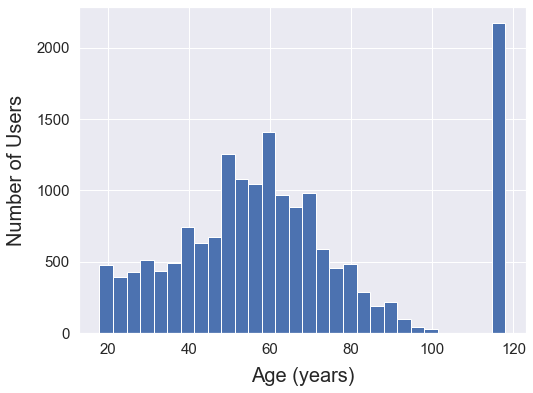

In [73]:
sns.set()
plt.figure(figsize = [8,6])
plt.hist(profile['age'], bins = 30);
plt.xlabel('Age (years)',fontsize=20,labelpad=10)
plt.ylabel('Number of Users',fontsize=20,labelpad=10);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

We might be surprised by the number of users with ages above 110, but if we have a closer look, we find that they are the same users who selected their gender as **O** which is other than male or female, furthermore they all have an exact age of 118, and Null values for their income.

In [74]:
profile[profile['age']==118].shape[0]

2175

In [75]:
profile[profile['income'].isnull()].shape[0]

2175

In [76]:
profile[(profile['age']==118) & (profile['income'].isnull()) & (profile['gender_O'] ==1)].shape[0]

2175

We therefore deduce that those are users who don't prefere to share their personal information, this is normal in reality, but we can benifit from this by classifing them into a group of users who prefere to stay `anonymous`. we therefore create a new column to identify them and see their distribution in the dataset.

In [77]:
profile['anonymous'] = profile.apply(lambda x: 1 if x['age']==118 else 0,axis=1)

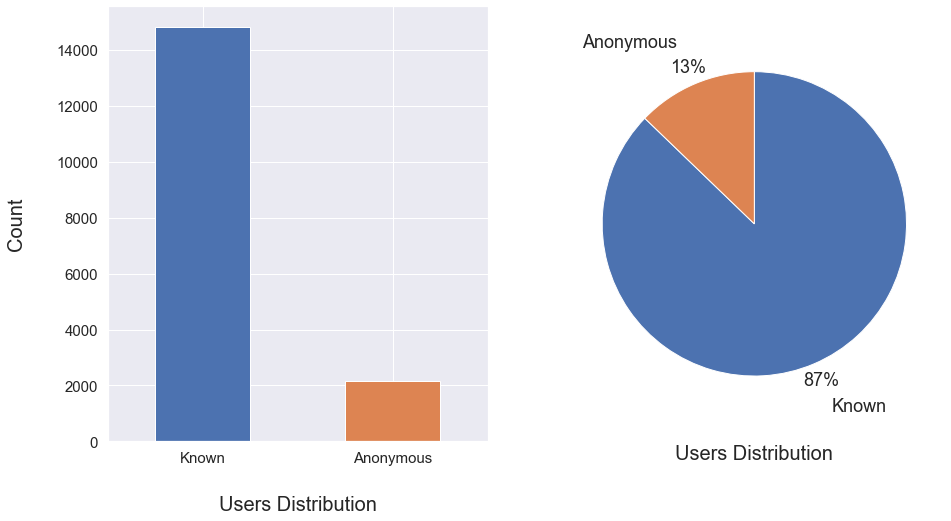

In [82]:
anon_dist = profile['anonymous'].value_counts()

plt.figure(figsize = [15,8])
base_color = sns.color_palette()

# Bar chart
plt.subplot(1,2,1)
anon_dist.plot(kind='bar',color=base_color)

plt.xticks(ticks = [0,1], labels = ['Known','Anonymous'],rotation = 0,fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Count',fontsize=20,labelpad=30,rotation = 90)
plt.xlabel('Users Distribution',fontsize=20,labelpad=30)

# Pie chart
plt.subplot(1,2,2)
anon_dist.plot(kind='pie',startangle = 90,counterclock=False,autopct='%1.0f%%',labels=['Known','Anonymous'],\
               textprops={'fontsize': 18},pctdistance=1.12,labeldistance=1.3)
plt.ylabel('');
plt.xlabel('Users Distribution',fontsize=20,labelpad=30);


Now we repeat the exploration of the age distribution after excluding those who want to stay anonymous.

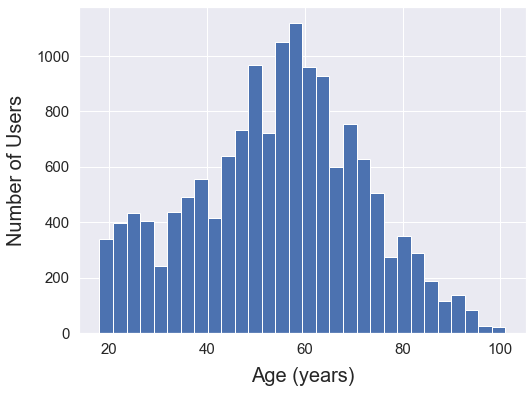

In [83]:
age_dist = profile[profile['anonymous']==0]['age']
plt.figure(figsize = [8,6])
plt.hist(age_dist, bins = 30);
plt.xlabel('Age (years)',fontsize=20,labelpad=10)
plt.ylabel('Number of Users',fontsize=20,labelpad=10);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

We can see that the majority of users are in their late 50's or early 60's, and that the number of users decreases as we move away from the peak. Next we want to see the distribution of the gender, we take into consideration the portion of users who stayed anonymous by removing them from the '**Other**' gender.

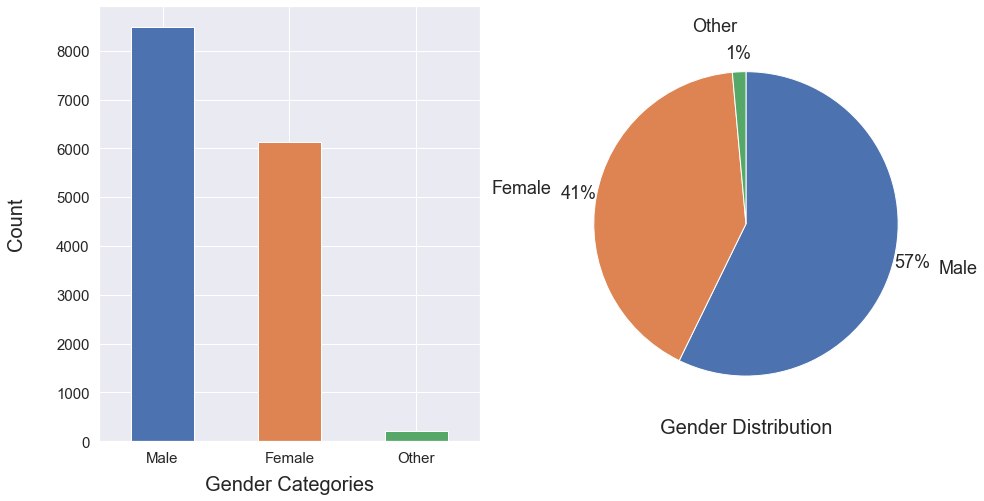

In [84]:
# Filter Gender Categories by removing anonymous users
gend_dist = profile[profile['anonymous']==0][['gender_M','gender_F','gender_O']].sum()

# Plotting
plt.figure(figsize = [15,8])

# Bar chart
plt.subplot(1,2,1)
gend_dist.plot(kind='bar',color=base_color)

plt.xticks(ticks = [0,1,2], labels = ['Male','Female','Other'],rotation = 0,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Gender Categories',fontsize=20,labelpad=10)
plt.ylabel('Count',fontsize=20,labelpad=30,rotation = 90)

# Pie chart
plt.subplot(1,2,2)
gend_dist.plot(kind='pie',startangle = 90,counterclock=False,autopct='%1.0f%%',\
               labels=['Male','Female','Other'],\
               textprops={'fontsize': 18},pctdistance=1.12,labeldistance=1.3)
plt.ylabel('')
plt.xlabel('Gender Distribution',fontsize=20);

It can be seen that their is 16% more males than females, and that 1% chose the '**Other**' option. Finally we present a  distribution of the user incomes.

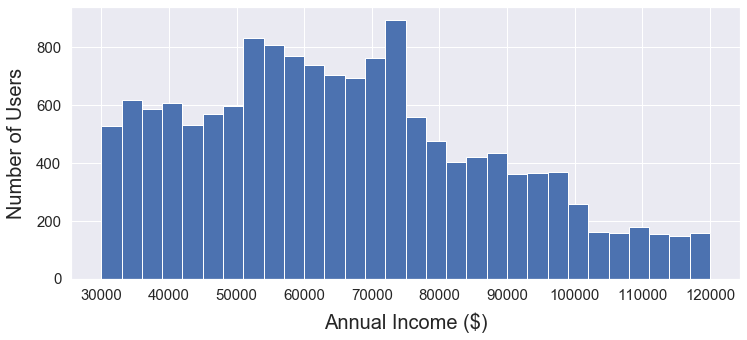

In [85]:
inc_dist = profile[profile['anonymous']==0]['income']
plt.figure(figsize = [12,5])
plt.hist(inc_dist, bins = 30);
plt.xlabel('Annual Income ($)',fontsize=20,labelpad=10)
plt.ylabel('Number of Users',fontsize=20,labelpad=10);
plt.xticks(range(30000,130000,10000),fontsize=15);
plt.yticks(fontsize=15);

Many users have an annual income in the range between 30000\\$ and 50000\\$, but the majority are in the range between 50000\\$ and 75000\\$, and of course less users have high annual salary.

Now we can start exploring the **transcript** dataset, first we see how the data is divided between different events.

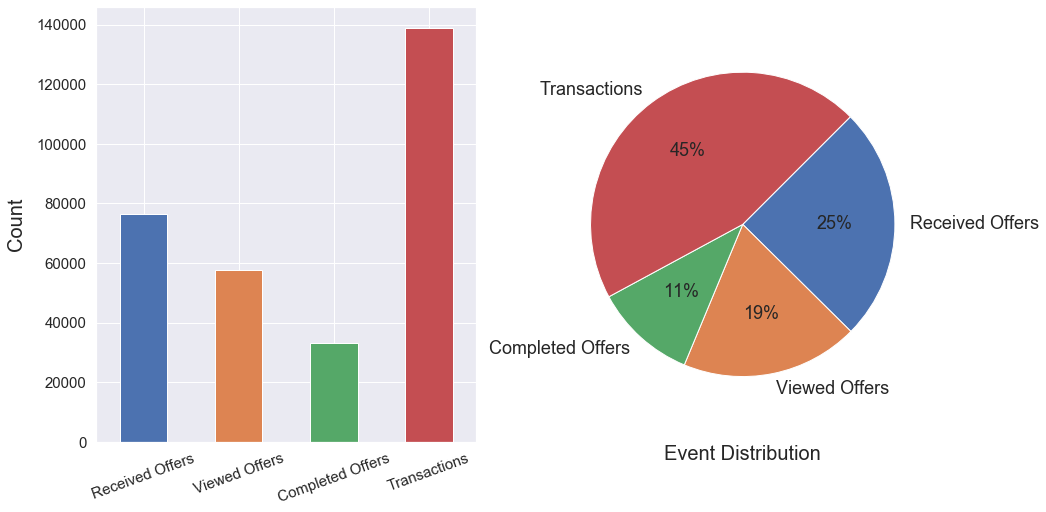

In [87]:
event_dist = transcript[['offer received','offer viewed','offer completed','transaction']].sum()

# Plotting
plt.figure(figsize = [15,8])

# Bar chart
plt.subplot(1,2,1)
event_dist.plot(kind='bar',color=base_color)
plt.xticks(ticks=[0,1,2,3],labels=['Received Offers','Viewed Offers','Completed Offers','Transactions'],rotation = 20,\
          fontsize=15);
plt.ylabel('Count',fontsize=20,labelpad=10,rotation = 90)
plt.yticks(fontsize=15);

# Pie chart
plt.subplot(1,2,2)
event_dist.plot(kind='pie',startangle = 45,counterclock=False,autopct='%1.0f%%',\
                labels=['Received Offers','Viewed Offers','Completed Offers','Transactions'],\
                textprops={'fontsize': 18})
plt.ylabel('')
plt.xlabel('Event Distribution',fontsize=20,labelpad=30);


We can see, the dataset has 2 types of events:
* **Offer** - which is further divided into 3 groups
    * Received Offers
    * Viewed Offers
    * Completed Offers
    
* **Transaction** - which holds records where a transaction occurred

The offers make up to 55% of the dataset leaving 45% for transactions. As expected, not all users who received the offer viewed it, and not all users who viewed the offer completed it. 

We can see the percentage of viewed offers from all sent ones.

In [88]:
transcript[transcript['offer viewed']==1].shape[0]/transcript[transcript['offer received']==1].shape[0]*100

75.67812053436815

There are two interesting questions here:

1. which transactions were completed because of the sent offer?
2. what are the characteristics of users who complete the offers?

To answer those questions we need to combine the datasets together. We'll rename some columns to simplify the merging step.

In [23]:
portfolio.rename(columns={"id":"offer_id","reward":"offer_reward"},inplace=True)
transcript.rename(columns={"person":"user_id","offer viewed":"offer_viewed",\
                           "offer received":"offer_received",\
                          "offer completed":"offer_completed"},inplace=True)
profile.rename(columns={"id":"user_id"},inplace=True)

Now we are ready to merge the dataframes.

In [24]:
pd.set_option('display.max_columns', None)
df = pd.merge(pd.merge(transcript, portfolio, on='offer_id',how='left'), profile, on='user_id')

If we compare the reward_given and the offer_reward columns we can find that they're identicle whenever there is an offer completed event. So we can drop the reward_given column.

In [25]:
(df[df['reward_given']>0]['reward_given'] - df[df['reward_given']>0]['offer_reward']).sum()

0.0

In [26]:
df.drop(['reward_given'],axis =1,inplace=True)

Now we can see the distribution of sent offers.

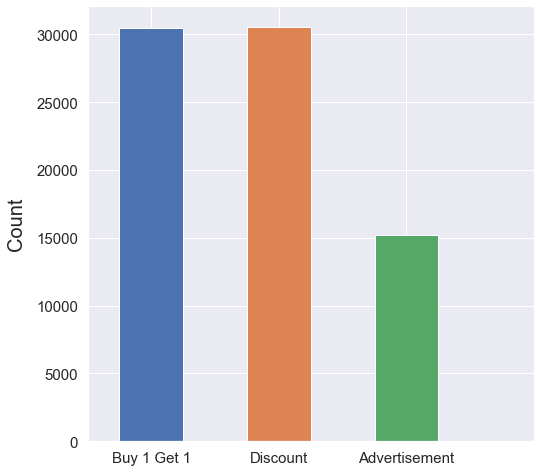

In [90]:
offer_types_dist = df[df['offer_received']==1][['is_bogo','is_discount','is_informational']].sum()

# Plotting
plt.figure(figsize = [8,8])

# Bar chart
offer_types_dist.plot(kind='bar',color=base_color)
plt.xticks(ticks=[0,1,2,3],labels=['Buy 1 Get 1','Discount','Advertisement'],rotation = 0,fontsize=15);
plt.ylabel('Count',fontsize=20,labelpad=10,rotation = 90)
plt.yticks(fontsize=15);

We can see that almost the same number of **BOGO** and **Discount** offers are sent, which is almost double the number of **Advertisement** offers sent.

Now we select records where transactions occurred after receiving an offer and while that offer is valid. We first divide the dataframe into 3 groups depending on the type of event, then we add an **offer_expiration** column. This will simplify extracting useful information. 

In [91]:
# Dataframe holding the events where an offer was received
offer_received_df = df[df['offer_received'] == 1][['offer_id','user_id','time','duration']]\
.rename(columns={"time":"time_received"})

# Dataframe holding the events where an offer was viewed
offer_viewed_df = df[df['offer_viewed'] == 1][['offer_id','user_id','time']]

# Dataframe holding the events where an offer was completed
offer_completed_df = df[df['offer_completed'] == 1][['offer_id','user_id','time']]

Now we merge those dataframes on the **user_id** and **offer_id** columns, to be able to compare the time between transactions.

In [92]:
# merge completed and viewd dataframes
merged_df = pd.merge(offer_completed_df,offer_viewed_df, on=['offer_id','user_id'],\
                     suffixes=('_completed','_viewed'))

# merge them with received dataframe
merged_df = pd.merge(merged_df,offer_received_df, on=['offer_id','user_id'])

Calculate offer deadline.

In [93]:
merged_df['offer_deadline'] = merged_df.apply(lambda x: x['time_received']+int(x['duration'])*24,axis =1)

Also we can make sure that no user completed an offer in the same hour twice. This will allow us to remove duplicate values in the merged dataframe.

In [94]:
df[(df['offer_completed']==1)].groupby(['offer_id','user_id','time']).size().max()

1

And same for the offer received.

In [32]:
df[(df['offer_received']==1)].groupby(['offer_id','user_id','time']).size().max()

1

In [33]:
# Remove duplicate rows
clean_df = merged_df.drop_duplicates(subset=['offer_id','user_id','time_completed'])
clean_df = clean_df.drop_duplicates(subset=['offer_id','user_id','time_received'])

Now we can easily see select users who completed the offer after viewing it and before it expires.

In [95]:
clean_df = clean_df[(clean_df['time_viewed'] >= clean_df['time_received']) &\
                 (clean_df['time_completed'] <= clean_df['offer_deadline'])]
clean_df

,offer_id,user_id,time_completed,time_viewed,time_received,duration,offer_deadline,offer_success
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,132,6,0,7.0,168,1
1,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,510,408,408,7.0,576,1
2,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,510,582,504,5.0,624,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,522,420,408,7.0,576,1
4,fafdcd668e3743c1bb461111dcafc2a4,e2127556f4f64592b11af22de27a7932,522,522,504,10.0,744,1
...,...,...,...,...,...,...,...,...
59943,4d5c57ea9a6940dd891ad53e9dbe8da0,3a298dbf99ef4a23b9b46a1500e56101,588,582,576,5.0,696,1
59944,9b98b8c7a33c4b65b9aebfe6a799e6d9,bad805c0568d49ae9bf2f046b6ea2be0,678,606,576,7.0,744,1
59945,f19421c1d4aa40978ebb69ca19b0e20d,fc966e9c3edc4578a1fb4c6a8c2659c2,528,516,504,5.0,624,1
59946,2298d6c36e964ae4a3e7e9706d1fb8c2,fc966e9c3edc4578a1fb4c6a8c2659c2,654,594,576,7.0,744,1


And if we compare this result with the original number of people who completed an offer, we can see the number of people who completed an offer **after** viewing it versus those who completed it without viewing. To do this we'll mark the users we found and combine this result with the original dataframe.

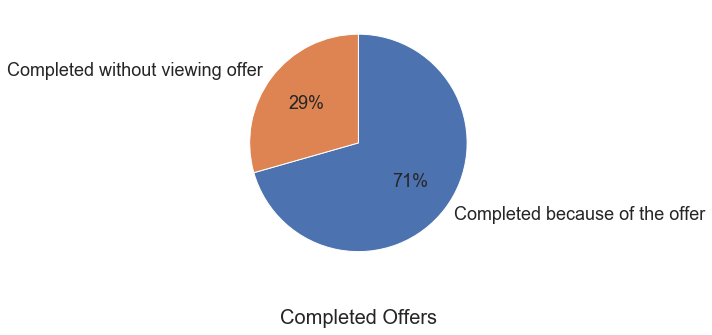

In [96]:
# mark users
clean_df['offer_success'] =1

# Merge dataframes on index
df1=df[df['offer_completed']==1].set_index(['offer_id','user_id','time'])
df2 = clean_df.rename(columns={"time_completed":"time"}).set_index(['offer_id','user_id','time'])['offer_success']
completed_offers_df = pd.merge(df1,df2,left_index=True,right_index=True,how="left")

# replace NaN values in offer_success column with 0
completed_offers_df['offer_success'] = completed_offers_df['offer_success'].fillna(0)

# Pie chart
plt.figure(figsize = [8,5])

completed_offers_df['offer_success'].value_counts().plot(kind='pie',startangle = 90,counterclock=False,autopct='%1.0f%%',\
                labels=['Completed because of the offer','Completed without viewing offer'],\
                textprops={'fontsize': 18})
plt.ylabel('')
plt.xlabel('Completed Offers',fontsize=20,labelpad=30);

We can see that 71% of completed offers were made after users viewed them. Now we want to know the effect of advertisement on the transactions that users made. We can follow the previous steps to do that. 

In [97]:
# Dataframe holding the events where an advertisement offer was received
adv_received_df = df[(df['offer_received'] == 1) & (df['is_informational'] == 1)][['offer_id','user_id','time','duration']]\
.rename(columns={"time":"time_received"})

# Dataframe holding the events where an advertisement offer was viewed
adv_viewed_df = df[(df['offer_viewed'] == 1) & (df['is_informational'] == 1)][['offer_id','user_id','time']]

# Dataframe holding the events where a transaction took place
transaction_df = df[(df['transaction'] == 1)][['user_id','time','amount']]

# merge transaction and adv_viewd dataframes
merged_df_adv = pd.merge(transaction_df,adv_viewed_df, on=['user_id'],suffixes=('_transaction','_viewed'))

# merge them with received dataframe
merged_df_adv = pd.merge(merged_df_adv,adv_received_df, on=['offer_id','user_id'])

# Calculate deadline
merged_df_adv['adv_deadline'] = merged_df_adv.apply(lambda x: x['time_received']+int(x['duration'])*24,axis =1)

Make sure no user completed a transaction in the same hour twice. 

In [98]:
df[(df['transaction']==1)].groupby(['user_id','time']).size().max()

1

In [99]:
# Remove duplicate rows
clean_adv_df = merged_df_adv.drop_duplicates(subset=['user_id','time_transaction'])

# Filter to get transactions that happened because of an advertisement
clean_adv_df = clean_adv_df[(clean_adv_df['time_transaction'] >= clean_adv_df['time_received']) &\
                 (clean_adv_df['time_transaction'] <= clean_adv_df['adv_deadline'])]

# mark users influenced by advertisement offer
clean_adv_df['offer_success'] =1

# Merge dataframes on index
df_adv1=df[df['transaction']==1].set_index(['user_id','time'])
df_adv2 = clean_adv_df.rename(columns={"time_transaction":"time"}).set_index(['user_id','time'])['offer_success']
adv_df = pd.merge(df_adv1,df_adv2,left_index=True,right_index=True,how="left")

# replace NaN values in offer_success column with 0
adv_df['offer_success'] = adv_df['offer_success'].fillna(0)


Finally we combine both dataframes, to see the over all effect of an offer, whether it's **BOGO**, **Discount** or **Advertisement** on the behaviour of the user.

In [100]:
final_df = pd.concat([completed_offers_df.reset_index(),adv_df.reset_index()])

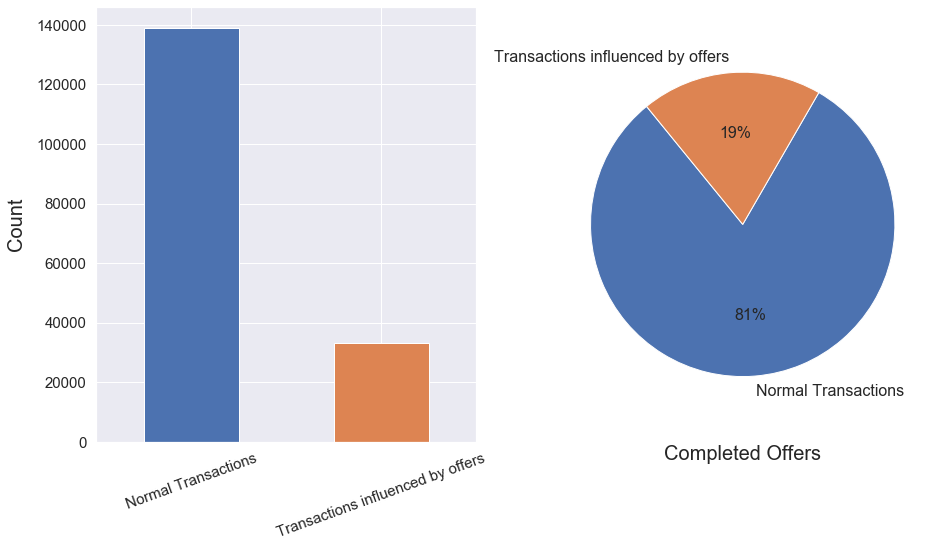

In [101]:
offer_influence = final_df['offer_success'].value_counts()
# Plotting
plt.figure(figsize = [15,8])

# Bar chart
plt.subplot(1,2,1)
offer_influence.plot(kind='bar',color=base_color)
plt.xticks(ticks=[0,1],labels=['Normal Transactions','Transactions influenced by offers'],rotation = 20,\
          fontsize=15);
plt.ylabel('Count',fontsize=20,labelpad=10,rotation = 90)
plt.yticks(fontsize=15);

# Pie chart
plt.subplot(1,2,2)

offer_influence.plot(kind='pie',startangle = 60,counterclock=False,autopct='%1.0f%%',\
                labels=['Normal Transactions','Transactions influenced by offers'],\
                textprops={'fontsize': 16})
plt.ylabel('')
plt.xlabel('Completed Offers',fontsize=20,labelpad=30);

As we can see, offers influence **19%** of the total transactions or completed offers that occured, that's pretty big. Now let's dive into the characteristics of those who are influenced by offers. First let's see how the gender affects the amount spent in a transaction, and which type of discount attracts which gender.

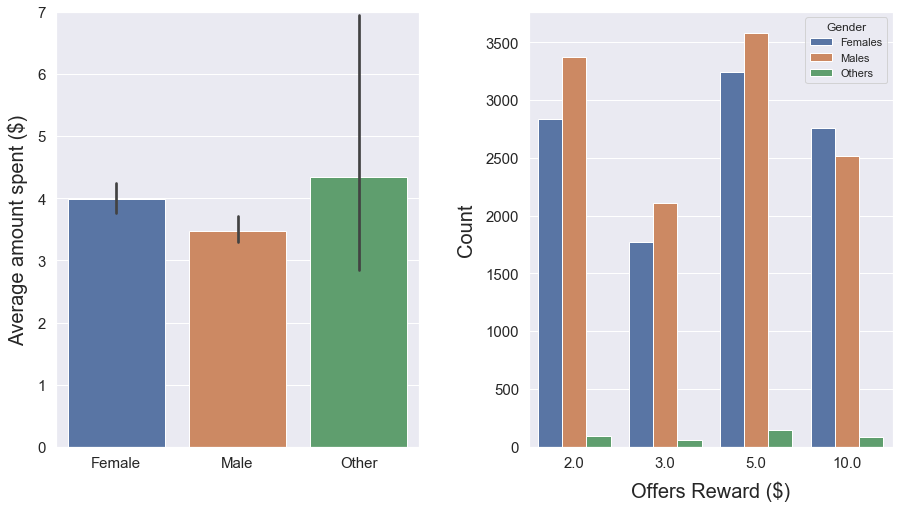

In [102]:
# Plotting
plt.figure(figsize = [15,8])
plt.subplots_adjust(wspace = 0.3)
# Box plot
plt.subplot(1,2,1)

sns.barplot(data = final_df[(final_df['anonymous']==0) &(final_df['offer_success']==1)],x='gender',y='amount');
plt.xticks(ticks=[0,1,2],labels=['Female','Male','Other'],fontsize=15)
plt.ylim([0,7])
plt.xlabel('');
plt.ylabel('Average amount spent ($)',fontsize=20,labelpad=10);
plt.yticks(fontsize=15);

# Clustered Bar chart
plt.subplot(1,2,2)

sns.countplot(data=final_df[(final_df['anonymous']==0) & (final_df['offer_success']==1)],x='offer_reward',hue='gender')
plt.legend(title='Gender', loc='upper right', labels=['Females', 'Males','Others']);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

plt.xlabel('Offers Reward ($)',fontsize=20,labelpad=10);
plt.ylabel('Count',fontsize=20,labelpad=10);

From the figure on the left, we can observe that on average, males spend the least compared to females and others, while **Others** category seems to be spending the most, it is probably due to their low number compared to males and females.  

On the right figure, we can see which type of offer rewards attract which genders, males seem to respond more to the 2, 3, and 5 dollar rewards while females respond more to the 10 dollar rewards

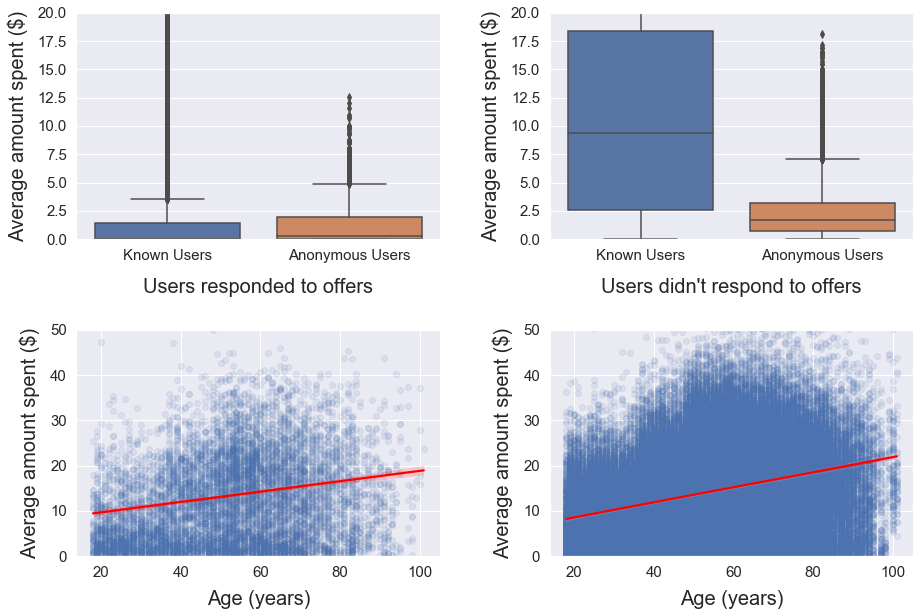

In [103]:
# Plotting
plt.figure(figsize = [15,10])
plt.subplots_adjust(wspace = 0.3)
plt.subplots_adjust(hspace = 0.4)

# Box plot
plt.subplot(2,2,1)

sns.boxplot(data = final_df[(final_df['offer_success']==1)],x='anonymous',y='amount');
plt.xticks(ticks=[0,1,],labels=['Known Users','Anonymous Users'],fontsize=15)
plt.ylim([0,20])
plt.ylabel('Average amount spent ($)',fontsize=20,labelpad=10);
plt.yticks(fontsize=15);
plt.xlabel('Users responded to offers',fontsize=20,labelpad=15);

# Box plot
plt.subplot(2,2,2)

sns.boxplot(data = final_df[(final_df['offer_success']==0)],x='anonymous',y='amount');
plt.xticks(ticks=[0,1,],labels=['Known Users','Anonymous Users'],fontsize=15)
plt.ylim([0,20])
plt.ylabel('Average amount spent ($)',fontsize=20,labelpad=10);
plt.yticks(fontsize=15);
plt.xlabel('Users didn\'t respond to offers',fontsize=20,labelpad=15);


# Clustered Bar chart
plt.subplot(2,2,3)

sns.regplot(data = final_df[(final_df['anonymous']==0) & (final_df['transaction']==1) & (final_df['offer_success']==1)]\
            ,x='age',y='amount',scatter_kws = {'alpha':1/10},line_kws={'color': 'red'});
plt.ylim([0,50]);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

plt.xlabel('Age (years)',fontsize=20,labelpad=10);
plt.ylabel('Average amount spent ($)',fontsize=20,labelpad=10);


# Clustered Bar chart
plt.subplot(2,2,4)

sns.regplot(data = final_df[(final_df['anonymous']==0) & (final_df['transaction']==1) & (final_df['offer_success']==0)]\
            ,x='age',y='amount',scatter_kws = {'alpha':1/10},line_kws={'color': 'red'});
plt.ylim([0,50]);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

plt.xlabel('Age (years)',fontsize=20,labelpad=10);
plt.ylabel('Average amount spent ($)',fontsize=20,labelpad=10);


We can see that the transaction amount that people spend as they get older increases in both groups, but that's pretty much all what we can get from the graph.

On the other hand we can see that people who choose to stay anonymous tend to spend more per transaction in the group that interacts with offers, however, on the other group it's completely the opposite, known users spend a lot more that anonymous users.

Now lets' compare the channels used.

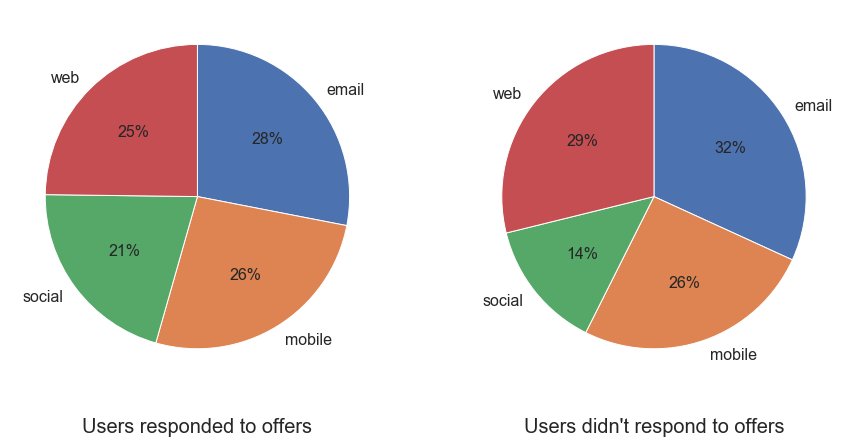

In [104]:
channel_dist_succ = final_df[(final_df['offer_success']==1)][['email','mobile','social','web']].sum()
channel_dist_fail = final_df[(final_df['offer_success']==0)][['email','mobile','social','web']].sum()

plt.figure(figsize = [15,8])
plt.subplot(1,2,1)

channel_dist_succ.plot(kind='pie',startangle = 90,counterclock=False,autopct='%1.0f%%',textprops={'fontsize': 16})
plt.ylabel('')
plt.xlabel('Users responded to offers',fontsize=20,labelpad=30);

plt.subplot(1,2,2)
channel_dist_fail.plot(kind='pie',startangle = 90,counterclock=False,autopct='%1.0f%%',textprops={'fontsize': 16})
plt.ylabel('')
plt.xlabel('Users didn\'t respond to offers',fontsize=20,labelpad=30);

We can see that although both groups do transactions, users respond more when sending offers through social media rather than email or web.

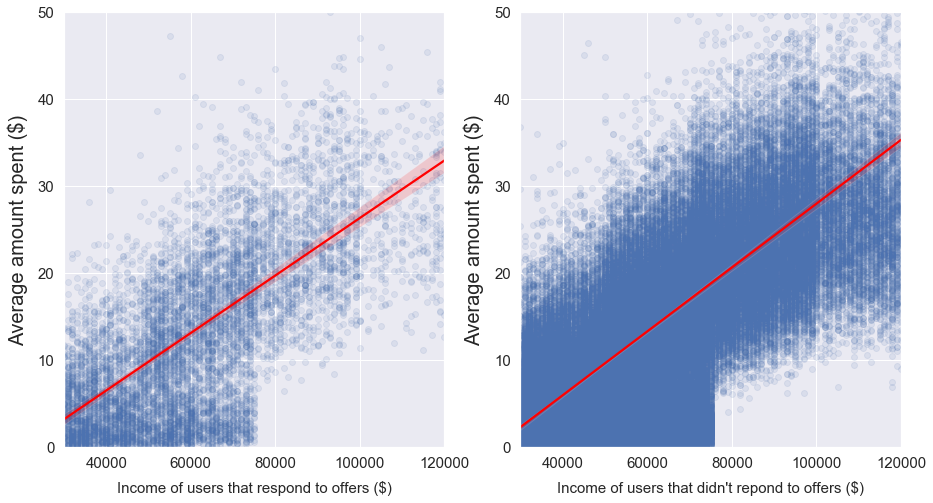

In [105]:
plt.figure(figsize = [15,8])

# Clustered Bar chart
plt.subplot(1,2,1)

sns.regplot(data = final_df[(final_df['anonymous']==0) & (final_df['transaction']==1) & (final_df['offer_success']==1)]\
            ,x='income',y='amount',scatter_kws = {'alpha':1/10},line_kws={'color': 'red'});
plt.ylim([0,50]);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

plt.xlabel('Income of users that respond to offers ($)',fontsize=15,labelpad=10);
plt.ylabel('Average amount spent ($)',fontsize=20,labelpad=10);


# Clustered Bar chart
plt.subplot(1,2,2)

sns.regplot(data = final_df[(final_df['anonymous']==0) & (final_df['transaction']==1) & (final_df['offer_success']==0)]\
            ,x='income',y='amount',scatter_kws = {'alpha':1/10},line_kws={'color': 'red'});
plt.ylim([0,50]);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

plt.xlabel('Income of users that didn\'t repond to offers ($)',fontsize=15,labelpad=10);
plt.ylabel('Average amount spent ($)',fontsize=20,labelpad=10);

We can see that in both groups, the amount spent per transaction is more when the user income is more, which is expected. Next, let's see how the age plays role in responding to offer rewards.

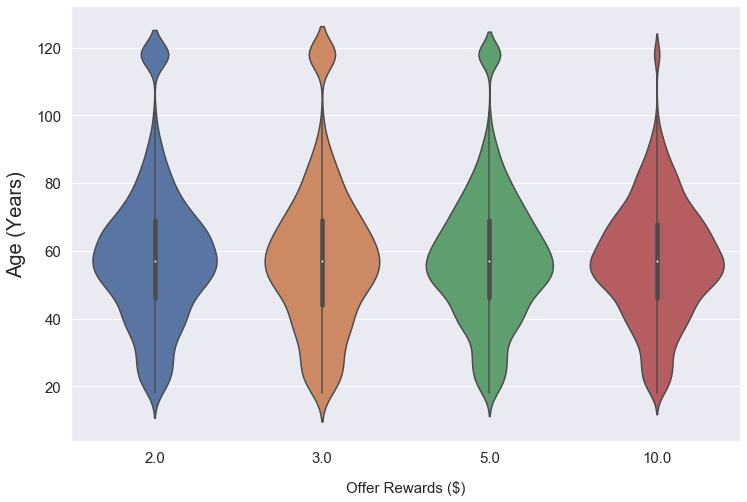

In [106]:
# Plotting
plt.figure(figsize = [12,8])

sns.violinplot(data = final_df[(final_df['offer_success']==1)],x='offer_reward',y='age');
plt.xticks(fontsize=15)
plt.ylabel('Age (Years)',fontsize=20,labelpad=10);
plt.yticks(fontsize=15);
plt.xlabel('Offer Rewards ($)',fontsize=15,labelpad=15);


We can see that age doesn't change play a big role in responding to offers.


## Data Modeling

### Predicting User Response

Now it's time to see if we can predict whether a user will respond to an offer or not, to do that we'll select the **offer_success** column to be the predicted value **Y**, and **X** to contain features about user demographics. After comparing different models we choose LinearSVC from sklearn.

In [108]:
# Drop unwanted columns
model_df = final_df.drop(['offer_id','user_id','time','offer_received','offer_viewed',\
                          'is_informational','offer_type','gender','email','became_member_on']\
                         ,axis=1)
# Fill Nan values with zeros
model_df[['offer_reward','difficulty','duration','is_bogo','is_discount','mobile','social','web']] =\
model_df[['offer_reward','difficulty','duration','is_bogo','is_discount','mobile','social','web']].fillna(0)

# Fill NaN values in income with mean value
model_df['income'] = model_df['income'].fillna(model_df['income'].mean())

In [109]:
# Select X and y
X = model_df.drop(['offer_success'],axis=1)
y = model_df['offer_success']
# Split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

# We use a pipeline to tune the parameters with grid search
pipeline = Pipeline(
        [
            ("clf", LinearSVC(dual=False)),
        ]
    )
parameters = {"clf__C": [1, 100]}
cv = GridSearchCV(pipeline, param_grid=parameters)

Now we train the model.

In [110]:
cv.fit(X_train, Y_train);

## Model Evaluation

We use the classification report from sklearn to evaluate the model.

In [112]:
y_pred = cv.predict(X_test)
print(classification_report(Y_test, y_pred, target_names=['Will not respond','Will respond']))

                  precision    recall  f1-score   support

Will not respond       0.91      0.94      0.92     27753
    Will respond       0.70      0.60      0.65      6674

        accuracy                           0.87     34427
       macro avg       0.80      0.77      0.78     34427
    weighted avg       0.87      0.87      0.87     34427



The results show that the model predicted those who will most probably not respond to an offer pretty good with an F1-score of 0.92, on the other hand, the prediction for those who will respond to offer wasn't as good with an F1-score of 0.65. The average accuracy of the model is 0.87 which is good.

## Justification

In analysis above, we discussed how user demographics and the offer reward affect their response to offers or advertisements sent. First, we identified users who don't prefere to share their personal information, and we classified them into a group of users who prefere to stay `anonymous`. We saw that they form 13% of the total users. This helped us identify accurately the gender distribution in the dataset. We saw that males take up 57% of total users and females take up 41%, leaving 1% for others.

Next we saw that the majority of users are in their late 50's or eary 60's, and that the number of users decreases as we move away from the peak. We also saw that age doesn't affect the user attraction to certain offer rewards. However, it was seen that the average amount spent per transaction increases as user age increases.

Many users have an annual income in the range between 30000\\$ and 50000\\$, but the majority are in the range between 50000\\$ and 75000\\$, and of course less users have high annual salary. The amount spent per transaction is more when the user income is more, which is expected.

After that we saw that 75% of all the received offers were actually viewed, and that 71% of users complete offers after they view them leaving 29% completing offers unintentionally.

It was seen that offers influence 19% of the total transactions or completed offers that occured, which is pretty big, and that users are 7% more likely to respond to offers when they are sent through social media.

We saw how gender plays role in the average amount spent by a user, and also in responding to which type of offer reward. Males responded more to the 2, 3, and 5 dollar rewards while females respond more to the 10 dollar rewards, and on average, females spend more than males.

People who chose to stay anonymous tend to spend more per transaction in the group that responded to offers, however, for the other group it's completely the opposite, known users spend a lot more than anonymous users.

Finally, we built a model that predicts whether a user will respond to an offer or not based of demographics and offer reward, and the model predicted this with an accuracy of 87%, an F1-score of 0.65 for identifing those who will repond to offers, and an F1-score of 0.92 for those who will not.

## Conclusion

### Reflection

The process used in this project can be summarized into the following steps:

1. Generate columns for categorical values and remove not used columns.
2. Explore data, analyse user demographics and events and offer type distribution.
3. Identify the cause of each event by comparing it with the time a relevant offer was sent and offer's duration.
4. Visualizing the relationship between user demographics and user actions whether its responding to events or performing transactions.
5. Predicting user behavior based on demographics and offer reward.  

I found step 3 most challenging because the data contains unrelated records, the same offer can be sent to the same user multiple times and I had to identify which offers the user responded to.

### Improvement

To improve prediction results we can consider increase the data size by collecting data over a larger period of time. In this project, the data was collected over a period of one month, but we don't know which day the experiment started, some people may pay more in the start of the month than they would at the end. So I expect that collecting data over 3 months or more will show a big improvement in the prediction results. 

